<a href="https://colab.research.google.com/github/enxo7899/INM705_Deep_Learning_for_Image_Analysis_Object_Detection/blob/main/pre_trained_F_r_CNN_finetunned_final_ready_to_run_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.9 MB/s eta 0:00:00


In [2]:
!pip install torch torchvision scikit-learn
!pip install seaborn


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [3]:
import torchvision
from torchvision.datasets import VOCDetection

# Define a mapping from class names to integers
CLASS_NAMES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair",
    "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "sofa", "train", "tvmonitor"
]

# Function to download the VOC2012 dataset
def download_voc_dataset(root='./data', year='2012'):
    # Download the train dataset
    VOCDetection(root=root, year=year, image_set='train', download=True)
    # Download the validation dataset
    VOCDetection(root=root, year=year, image_set='val', download=True)
    print("VOC 2012 dataset downloaded successfully.")

# Call the function to download the dataset
download_voc_dataset()


100%|██████████| 1999639040/1999639040 [02:07<00:00, 15708590.88it/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
VOC 2012 dataset downloaded successfully.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Epoch [1/5], Step [0/1001], Loss: 1.3561
Epoch [1/5], Step [10/1001], Loss: 0.3028
Epoch [1/5], Step [20/1001], Loss: 0.2337
Epoch [1/5], Step [30/1001], Loss: 0.6253
Epoch [1/5], Step [40/1001], Loss: 0.7904
Epoch [1/5], Step [50/1001], Loss: 0.4748
Epoch [1/5], Step [60/1001], Loss: 0.4928
Epoch [1/5], Step [70/1001], Loss: 0.6227
Epoch [1/5], Step [80/1001], Loss: 0.3832
Epoch [1/5], Step [90/1001], Loss: 0.3824
Epoch [1/5], Step [100/1001], Loss: 0.4802
Epoch [1/5], Step [110/1001], Loss: 0.2837
Epoch [1/5], Step [120/1001], Loss: 0.3617
Epoch [1/5], Step [130/1001], Loss: 0.1777
Epoch [1/5], Step [140/1001], Loss: 0.4048
Epoch [1/5], Step [150/1001], Loss: 0.1859
Epoch [1/5], Step [160/1001], Loss: 0.6434
Epoch [1/5], Step [170/100

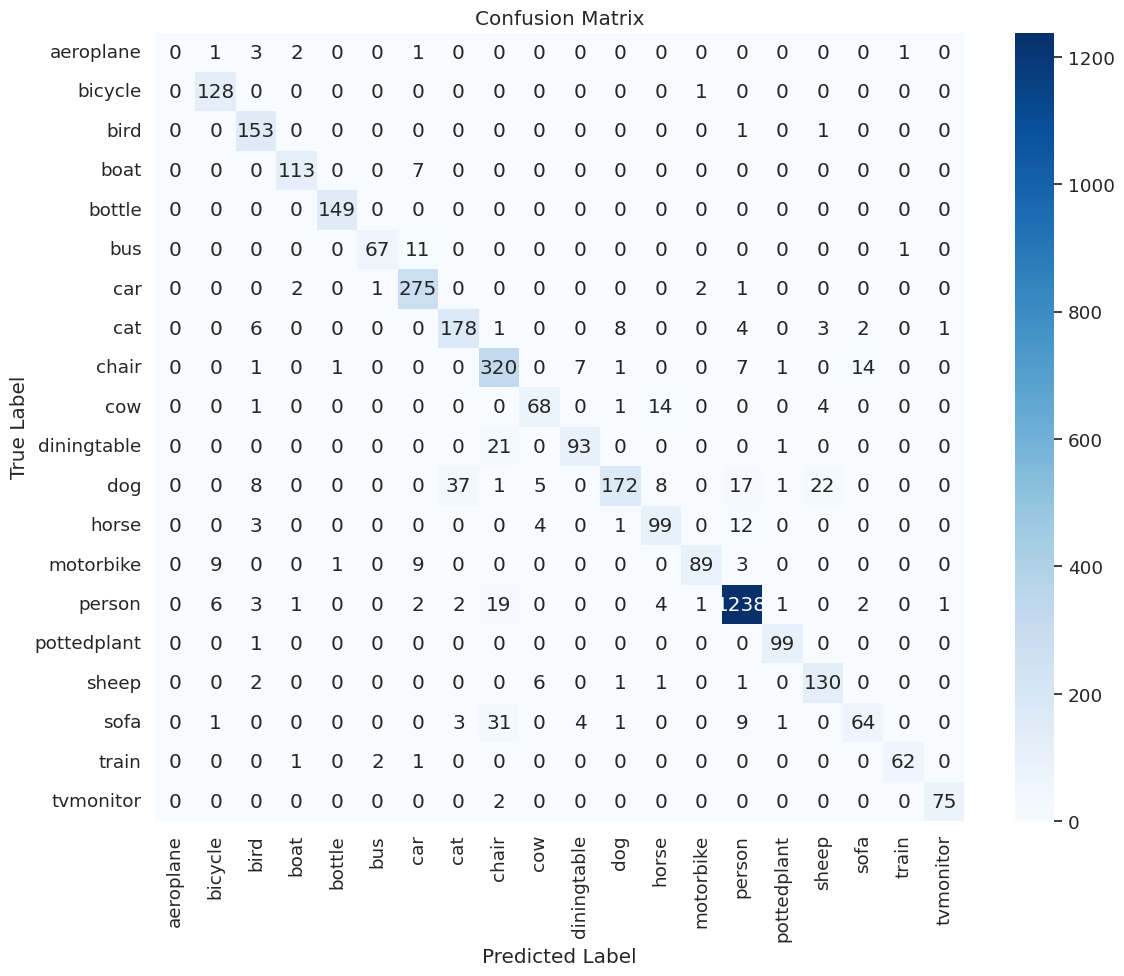

In [3]:
import torch
import torchvision
from torchvision.datasets import VOCDetection
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, random_split
import torchvision.models.detection as models
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import numpy as np
from torchvision.ops import box_iou
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import os

# Initialize WandB for experiment tracking
api_key = "9ce954fd827fd8d839648cb3708ff788ad51bafa"
wandb.login(key=api_key)
wandb.init(project="faster-rcnn-project-pretrained-unchanged", entity="enxo7899")

# Hyperparameters and configuration
hyperparams = {
    "batch_size": 4,            # Batch size for training
    "num_workers": 2,           # Number of workers for data loading
    "learning_rate": 0.005,     # Learning rate for optimizer
    "momentum": 0.9,            # Momentum for SGD
    "num_epochs": 5,           # Number of training epochs
    "iou_threshold": 0.5,       # IoU threshold for evaluation
}

# Check if GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a mapping from class names to integers
CLASS_NAMES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair",
    "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "sofa", "train", "tvmonitor"
]
CLASS_NAME_TO_IDX = {name: i for i, name in enumerate(CLASS_NAMES)}

# Download and prepare the VOC2012 dataset
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, root, year, image_set, transforms):
        self.dataset = VOCDetection(root, year=year, image_set=image_set, download=True)
        self.transforms = transforms

    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        target = self.dataset[idx][1]
        target = self._convert_target(target)

        if self.transforms:
            image = self.transforms(image)

        return image, target

    def __len__(self):
        return len(self.dataset)

    def _convert_target(self, target):
        # Convert the target from the VOC format to a format compatible with Faster R-CNN
        boxes = []
        labels = []
        objects = target['annotation']['object']
        if isinstance(objects, dict):  # Handle the case where there's only one object
            objects = [objects]

        for obj in objects:
            bbox = obj['bndbox']
            box = [
                int(bbox['xmin']),
                int(bbox['ymin']),
                int(bbox['xmax']),
                int(bbox['ymax'])
            ]
            boxes.append(box)
            labels.append(CLASS_NAME_TO_IDX[obj['name']])

        return {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'labels': torch.as_tensor(labels, dtype=torch.int64)
        }

# Define transformations
def get_transform(train):
    transforms = []
    transforms.append(F.to_tensor)
    return torchvision.transforms.Compose(transforms)

# Initialize dataset and dataloaders
full_dataset = VOCDataset(root='./data', year='2012', image_set='train', transforms=get_transform(train=True))
test_dataset = VOCDataset(root='./data', year='2012', image_set='val', transforms=get_transform(train=False))

# Split the dataset for training (70%) and validation (30%)
train_size = int(0.7 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Data loaders
data_loader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"], shuffle=True, num_workers=hyperparams["num_workers"], collate_fn=lambda x: tuple(zip(*x)))
data_loader_val = DataLoader(val_dataset, batch_size=hyperparams["batch_size"], shuffle=False, num_workers=hyperparams["num_workers"], collate_fn=lambda x: tuple(zip(*x)))
data_loader_test = DataLoader(test_dataset, batch_size=hyperparams["batch_size"], shuffle=False, num_workers=hyperparams["num_workers"], collate_fn=lambda x: tuple(zip(*x)))

# Load a pretrained Faster R-CNN model with ResNet-50 backbone
model = models.fasterrcnn_resnet50_fpn(weights=models.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
model.to(device)

# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=hyperparams["learning_rate"], momentum=hyperparams["momentum"])

# Directory for saving checkpoints
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Function to save a model checkpoint
def save_checkpoint(state, filename="checkpoint.pth.tar"):
    filepath = os.path.join(checkpoint_dir, filename)
    torch.save(state, filepath)
    print(f"Checkpoint saved to {filepath}")

# Function to load a model checkpoint
def load_checkpoint(filename="checkpoint.pth.tar"):
    filepath = os.path.join(checkpoint_dir, filename)
    if os.path.isfile(filepath):
        print(f"Loading checkpoint from {filepath}")
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("Checkpoint loaded successfully")
    else:
        print(f"No checkpoint found at {filepath}")

# Train the model
num_epochs = hyperparams["num_epochs"]  # Number of epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(data_loader)}], Loss: {losses.item():.4f}")

    epoch_loss = running_loss / len(data_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {epoch_loss:.4f}")

    # Log metrics to WandB
    wandb.log({"epoch": epoch + 1, "loss": epoch_loss})

    # Save checkpoint
    save_checkpoint({'epoch': epoch + 1, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()})

# Function to calculate evaluation metrics
def calculate_metrics(model, data_loader, device, iou_threshold=hyperparams["iou_threshold"]):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            outputs = model(images)

            for target, output in zip(targets, outputs):
                true_boxes = target['boxes'].to(device)
                true_labels = target['labels'].cpu().numpy()
                pred_boxes = output['boxes'].to(device)
                pred_labels = output['labels'].cpu().numpy()
                pred_scores = output['scores'].cpu().numpy()

                # Filter predictions by a score threshold (e.g., 0.5)
                keep = pred_scores > 0.5
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]

                # Calculate IoU between predicted and true boxes
                if len(pred_boxes) > 0 and len(true_boxes) > 0:
                    ious = box_iou(pred_boxes, true_boxes)
                    ious_max, indices = ious.max(dim=1)
                    matched = ious_max > iou_threshold

                    # Filter matched indices for valid IoU
                    matched_true_indices = indices[matched].cpu().numpy()
                    matched_pred_indices = np.where(matched.cpu().numpy())[0]

                    # Collect the matched true and predicted labels
                    y_true.extend(true_labels[matched_true_indices].tolist())
                    y_pred.extend(pred_labels[matched_pred_indices].tolist())

    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Log metrics to WandB
    wandb.log({"precision": precision, "recall": recall, "f1_score": f1})

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot the confusion matrix
    plot_confusion_matrix(conf_matrix, CLASS_NAMES)

def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(12, 10))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

# Calculate and print metrics on the validation dataset
calculate_metrics(model, data_loader_val, device)

# Finish WandB logging
wandb.finish()


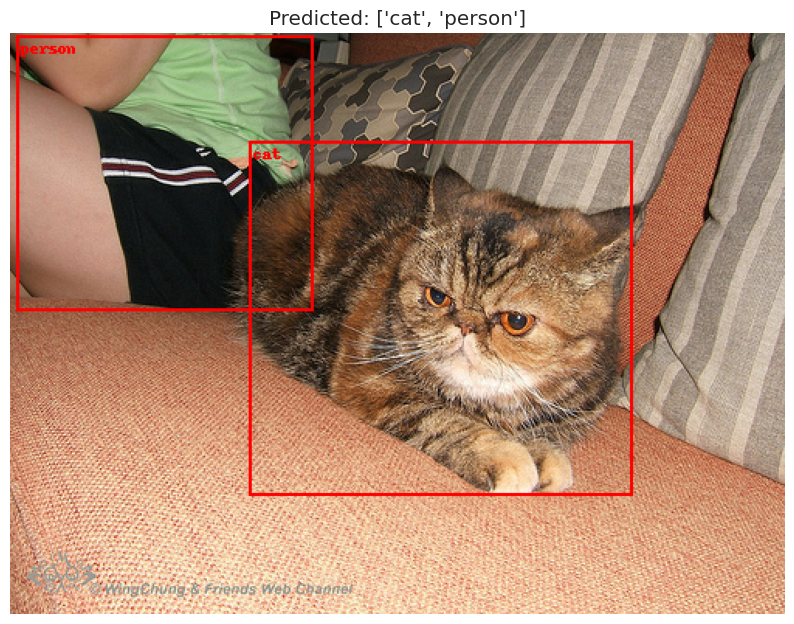

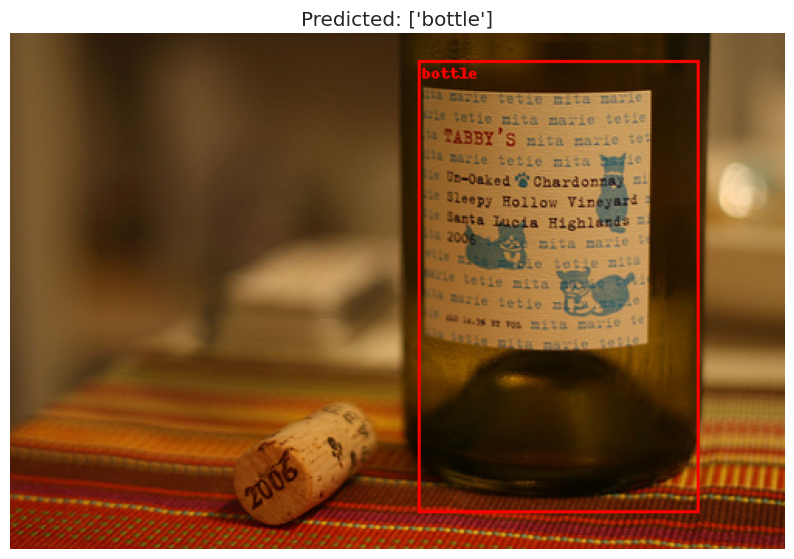

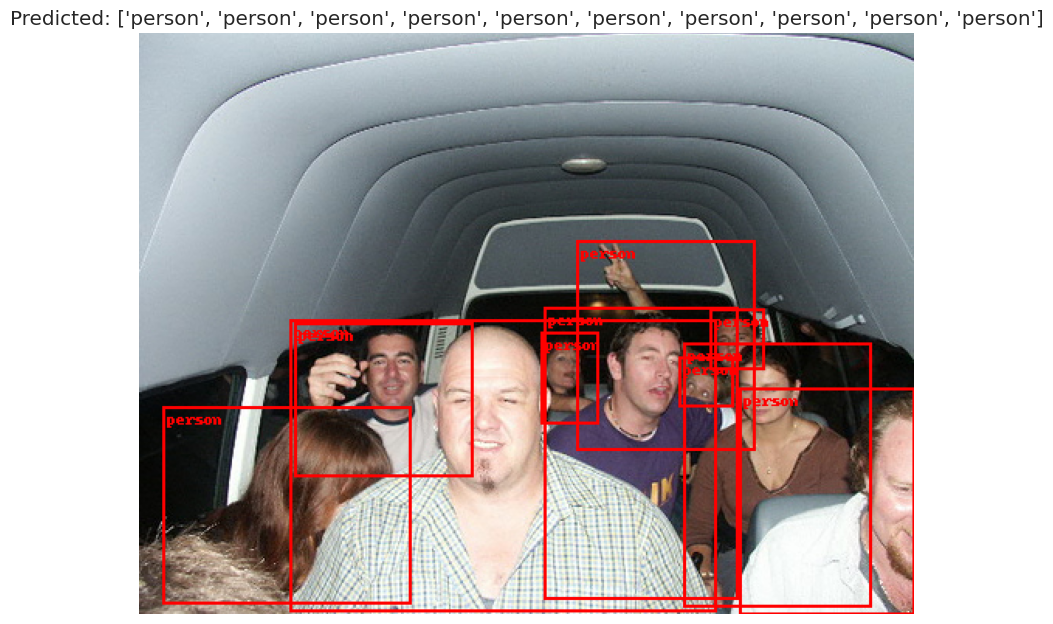

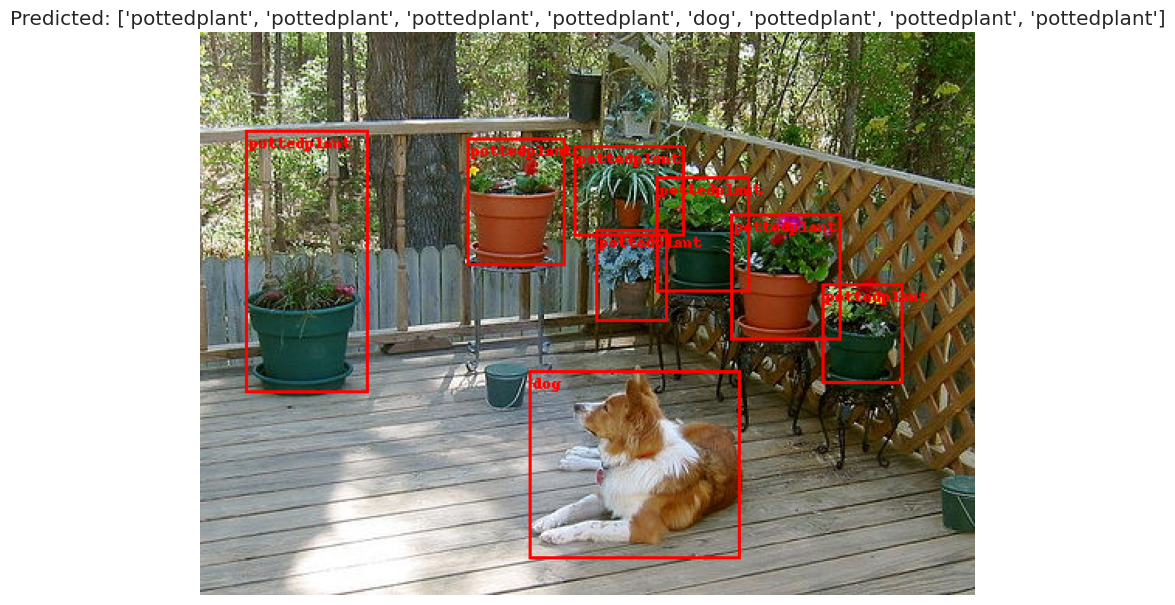

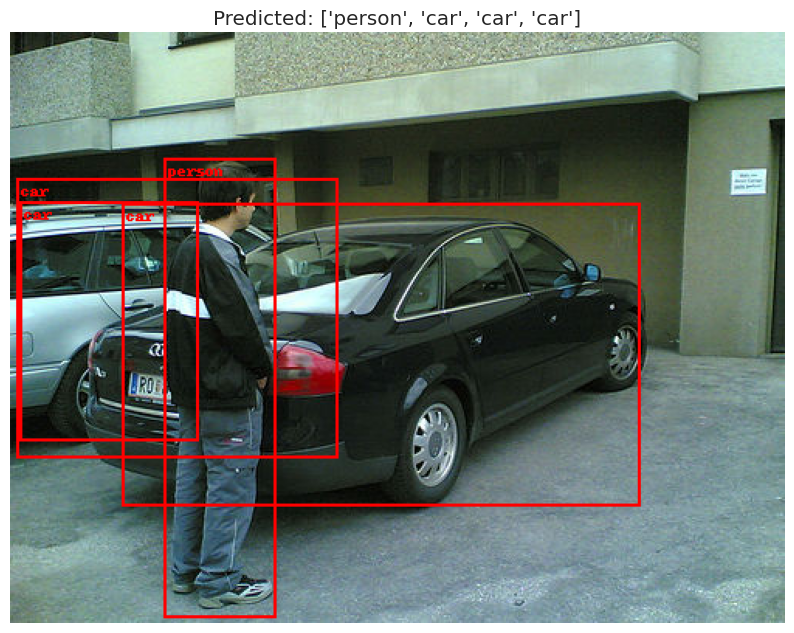

In [4]:
import torch
import torchvision.transforms as T
from torchvision.utils import draw_bounding_boxes
from PIL import Image
import matplotlib.pyplot as plt
import random

# Load a sample image from the dataset to test inference
def load_sample_image(dataset, index):
    image, target = dataset[index]
    return image, target

# Function to visualize predictions with bounding boxes and labels
def visualize_predictions(model, dataset, device, num_images=5):
    model.eval()  # Set the model to evaluation mode

    # Create a random list of image indices to visualize
    indices = random.sample(range(len(dataset)), num_images)

    for idx in indices:
        image, target = load_sample_image(dataset, idx)
        # Unsqueeze to add a batch dimension
        image = image.unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(image)

        # Get the predicted boxes, labels, and scores
        pred_boxes = outputs[0]['boxes'].cpu()
        pred_labels = outputs[0]['labels'].cpu()
        pred_scores = outputs[0]['scores'].cpu()

        # Filter predictions with score threshold
        score_threshold = 0.5
        keep = pred_scores > score_threshold
        pred_boxes = pred_boxes[keep]
        pred_labels = pred_labels[keep]
        pred_scores = pred_scores[keep]

        # Draw bounding boxes on the image
        label_names = [CLASS_NAMES[i] for i in pred_labels]
        drawn_image = draw_bounding_boxes(
            (image[0].cpu() * 255).byte(),
            boxes=pred_boxes,
            labels=label_names,
            colors="red",
            width=2,
        )

        # Convert drawn image tensor to PIL image for display
        pil_image = T.ToPILImage()(drawn_image)

        # Display the image with bounding boxes and labels
        plt.figure(figsize=(10, 10))
        plt.imshow(pil_image)
        plt.axis('off')
        plt.title(f"Predicted: {label_names}")
        plt.show()

# Visualize predictions on the test dataset
visualize_predictions(model, test_dataset, device)
